# Pruning

## 1. Setup

In [1]:
!nvidia-smi

Wed Dec  8 04:29:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           On   | 00000000:01:00.0 Off |                  N/A |
| 66%   84C    P2   248W / 280W |   8738MiB / 24219MiB |     93%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import gc
import time
import copy
import math
import hydra
import GPUtil 
import itertools
from tqdm.auto import tqdm
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl

from transformers import AutoModel, AutoModelForMaskedLM, AutoTokenizer, AutoConfig
from transformers import get_scheduler
from transformers import BatchEncoding
from transformers.data.data_collator import DataCollatorForWholeWordMask
from datasets import load_dataset, concatenate_datasets

In [3]:
with hydra.initialize('../configs'):
    config = hydra.compose('config.yaml', overrides=['working_dir=../', 'model.mlm=false', 'data.batch_size=16'])

## 2. Data

In [4]:
class DataModule(pl.LightningDataModule):
    def __init__(self, tokenizer, batch_size=8):
        super().__init__()
        self.tokenizer = tokenizer
        self.batch_size=batch_size
        
    def setup(self, stage=None):
        self.dataset = load_dataset('text', data_files=os.path.join('../data', 'kowiki.txt'))['train']
        self.dataset.set_transform(lambda batch: transform(batch, self.tokenizer, 512))
        self.dataset = self.dataset.train_test_split(test_size=0.01)
        self.train_dataset, self.eval_dataset = self.dataset['train'], self.dataset['test']
        

    def collate_fn(self, batch):
        batch = BatchEncoding(batch)
        batch['attention_mask'] = batch.input_ids.ne(self.tokenizer.pad_token_id).float()
        return batch

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
    
    def validation_dataloader(self):
        return torch.utils.data.DataLoader(self.eval_dataset, batch_size=self.batch_size, shuffle=False)

    
def transform(batch, tokenizer, max_length):
    new_batch = []
    for text in batch['text']:
        text = slice_text(text)
        new_batch.append(text)
    
    return tokenizer(new_batch, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')


def slice_text(text, max_char_length=1024):
    if len(text) > max_char_length:
        idx = np.random.randint(low=0, high=len(text)-max_char_length)
        text = text[idx : idx+max_char_length]
    return text

## 3. Model

In [202]:
def select_layers(model: torch.nn.Module, indices: List[int]):
    model.encoder.layer = nn.ModuleList([l for i, l in enumerate(model.encoder.layer) if i in indices])
    return model

def select_indices_from_embedding(embedding: torch.Tensor, num_features: int = 384, corr_threshold: float = 0.3):
    corr = torch.corrcoef(embedding.transpose(-1, -2))
    corr = corr - torch.eye(corr.size(0))
    
    removed_indices = []
    for idx in range(corr.size(0)):
        most_sim_idx = corr[idx].argmax()
        if corr[idx][most_sim_idx] > corr_threshold and idx > most_sim_idx:
            removed_indices.append(idx)
            
    norm = embedding.norm(dim=0)
    norm_indices = (-norm).argsort()

    indices = [int(i) for i in norm_indices if i not in removed_indices]
    indices = indices[:num_features]
    return indices

def select_weight(weight, indices, dim):
    if type(dim) == int:
        indices = torch.tensor(indices)
        return torch.index_select(weight, dim, indices.to(weight.device))
    
    else:
        for d in dim:
            weight = select_weight(weight, indices, d)
        return weight
    
AttributeError: 'Embedding' object has no attribute 'clone'


def select_layernorm(layernorm, indices):
    layernorm.weight.data = select_weight(layernorm.weight.data, indices, dim=0)
    layernorm.bias.data = select_weight(layernorm.bias.data, indices, dim=0)
    layernorm.normalized_shape = (len(indices), )
    return layernorm

def select_linear(linear, indices, dims=[0, 1]):
    linear.weight.data = select_weight(linear.weight.data, indices, dim=dims)
    if 0 in dims:
        linear.bias.data = select_weight(linear.bias.data, indices, dim=0)
        
    if 1 in dims:
        linear.in_features = len(indices)
    if 0 in dims:
        linear.out_features = len(indices)
    return linear

def select_bert_embeddings(bert_embeddings, indices):
    bert_embeddings.word_embeddings = select_embedding(bert_embeddings.word_embeddings, indices)
    bert_embeddings.position_embeddings = select_embedding(bert_embeddings.position_embeddings, indices)
    bert_embeddings.token_type_embeddings = select_embedding(bert_embeddings.token_type_embeddings, indices)
    bert_embeddings.LayerNorm = select_layernorm(bert_embeddings.LayerNorm, indices)
    return bert_embeddings


def select_bert_layer(bert_layer, indices):
    bert_layer.attention.self.all_head_size = len(indices)
    bert_layer.attention.self.attention_head_size = len(indices) // bert_layer.attention.self.num_attention_heads
    
    bert_layer.attention.self.query = select_linear(bert_layer.attention.self.query, indices)
    bert_layer.attention.self.key = select_linear(bert_layer.attention.self.key, indices)
    bert_layer.attention.self.value = select_linear(bert_layer.attention.self.value, indices)
    
    bert_layer.attention.output.dense = select_linear(bert_layer.attention.output.dense, indices)
    bert_layer.attention.output.LayerNorm = select_layernorm(bert_layer.attention.output.LayerNorm, indices)
    
    bert_layer.intermediate.dense = select_linear(bert_layer.intermediate.dense, indices, dims=[1])
    bert_layer.output.dense = select_linear(bert_layer.output.dense, indices, dims=[0])
    bert_layer.output.LayerNorm = select_layernorm(bert_layer.output.LayerNorm, indices)
    return bert_layer

def select_bert_pooler(bert_pooler, indices):
    bert_pooler.dense = select_linear(bert_pooler.dense, indices)
    return bert_pooler

def select_bert_model(bert_model, layer_indices, weight_indices):
    bert_model = select_layers(bert_model, layer_indices)
    bert_model.embeddings = select_bert_embeddings(bert_model.embeddings, weight_indices)
    bert_model.encoder.layer = nn.ModuleList([select_bert_layer(l, weight_indices) for l in bert_model.encoder.layer])
    bert_model.pooler = select_bert_pooler(bert_model.pooler, weight_indices)
    return bert_model

In [203]:
def to_distill(model):
    model.base_model.encoder.layer[0].attention.self.__class__._forward = bert_self_attention_forward
    for layer in model.base_model.encoder.layer:
        layer.attention.self.forward = layer.attention.self._forward
    
    for param in model.parameters():
        param.requires_grad = False
    return model


def bert_self_attention_forward(
    self,
    hidden_states,
    attention_mask=None,
    head_mask=None,
    encoder_hidden_states=None,
    encoder_attention_mask=None,
    past_key_value=None,
    output_attentions=False,
):
    mixed_query_layer = self.query(hidden_states)
    mixed_key_layer = self.key(hidden_states)
    mixed_value_layer = self.value(hidden_states)
    
    query_layer = self.transpose_for_scores(mixed_query_layer)
    key_layer = self.transpose_for_scores(mixed_key_layer)
    value_layer = self.transpose_for_scores(mixed_value_layer)
    
    self.q = mixed_query_layer # (Batch, Seq, Dim)
    self.k = mixed_key_layer # (Batch, Seq, Dim)
    self.v = mixed_value_layer # (Batch, Seq, Dim)

    if self.is_decoder:
        past_key_value = (key_layer, value_layer)

    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

    if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
        seq_length = hidden_states.size()[1]
        position_ids_l = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
        position_ids_r = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
        distance = position_ids_l - position_ids_r
        positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
        positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

        if self.position_embedding_type == "relative_key":
            relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
            attention_scores = attention_scores + relative_position_scores
        elif self.position_embedding_type == "relative_key_query":
            relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
            relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
            attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

    attention_scores = attention_scores / math.sqrt(self.attention_head_size)
    if attention_mask is not None:
        attention_scores = attention_scores + attention_mask

    attention_probs = nn.Softmax(dim=-1)(attention_scores)
    attention_probs = self.dropout(attention_probs)

    if head_mask is not None:
        attention_probs = attention_probs * head_mask

    context_layer = torch.matmul(attention_probs, value_layer)

    context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
    new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
    context_layer = context_layer.view(*new_context_layer_shape)

    outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)
    if self.is_decoder:
        outputs = outputs + (past_key_value,)
    return outputs


def get_qkvs(model):
    attns = [l.attention.self for l in model.base_model.encoder.layer]
    qkvs = [{'q': a.q, 'k': a.k, 'v': a.v} for a in attns]    
    return qkvs

def transpose_for_scores(h, num_heads):
    batch_size, seq_length, dim = h.size()
    head_size = dim // num_heads
    h = h.view(batch_size, seq_length, num_heads, head_size)
    return h.permute(0, 2, 1, 3) # (batch, num_heads, seq_length, head_size)


def attention(h1, h2, num_heads, attention_mask=None):
    assert h1.size() == h2.size()
    head_size = h1.size(-1) // num_heads
    h1 = transpose_for_scores(h1, num_heads) # (batch, num_heads, seq_length, head_size)
    h2 = transpose_for_scores(h2, num_heads) # (batch, num_heads, seq_length, head_size)

    attn = torch.matmul(h1, h2.transpose(-1, -2)) # (batch_size, num_heads, seq_length, seq_length)
    attn = attn / math.sqrt(head_size)
    if attention_mask is not None:
        attention_mask = attention_mask[:, None, None, :]
        attention_mask = (1 - attention_mask) * -10000.0
        attn = attn + attention_mask

    return attn


def kl_div_loss(s, t, temperature=1.):
    if len(s.size()) != 2:
        s = s.view(-1, s.size(-1))
        t = t.view(-1, t.size(-1))

    s = F.log_softmax(s / temperature, dim=-1)
    t = F.softmax(t / temperature, dim=-1)
    return F.kl_div(s, t, reduction='batchmean')

def minilm_loss(t, s, num_relation_heads, attention_mask=None):
    attn_t = attention(t, t, num_relation_heads, attention_mask)
    attn_s = attention(s, s, num_relation_heads, attention_mask)
    loss = kl_div_loss(attn_s, attn_t)
    return loss

## 4. Main

In [7]:
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

In [8]:
data_module = DataModule(tokenizer)
data_module.setup()
loader = iter(data_module.train_dataloader())

Using custom data configuration default-82324f4e586d6530
Reusing dataset text (/root/.cache/huggingface/datasets/text/default-82324f4e586d6530/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5)


  0%|          | 0/1 [00:00<?, ?it/s]

In [209]:
batch = next(loader)

In [45]:
model = AutoModel.from_pretrained('klue/bert-base', output_hidden_states=True, output_attentions=True)
model = to_distill(model)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [205]:
weight_indices = select_indices_from_embedding(model.embeddings.word_embeddings.weight.data, num_features=384, corr_threshold=0.3)

In [206]:
pruned = select_bert_model(model, layer_indices=list(range(6)), weight_indices=weight_indices)

In [210]:
out = pruned(**batch)

### Test

In [10]:
layer_scores = np.zeros(12)
weight_scores = np.zeros(768)

In [11]:
pbar = tqdm(range(1000))
for i in tqdm(pbar):
    layer_indices = np.random.choice(range(12), size=6, replace=False).tolist()
    weight_indices = np.random.choice(range(768), size=384, replace=False).tolist()
    
    batch = next(loader)
    batch = {k:v.cuda() for k,v in batch.items()}
    
    pruned = copy.deepcopy(model)
    pruned = select_bert_model(pruned, layer_indices, weight_indices)
    
    with torch.no_grad():
        model_out = model(**batch)
        pruned_out = pruned(**batch)
    
    model_qkvs = get_qkvs(model)[-1]
    pruned_qkvs = get_qkvs(pruned)[-1]
    
    loss_q = minilm_loss(model_qkvs['q'], pruned_qkvs['q'], 24, batch['attention_mask'])
    loss_k = minilm_loss(model_qkvs['k'], pruned_qkvs['k'], 24, batch['attention_mask'])
    loss_v = minilm_loss(model_qkvs['v'], pruned_qkvs['v'], 24, batch['attention_mask'])
    loss = loss_q + loss_k + loss_v
    loss = float(loss)
    
    layer_scores[layer_indices] += loss
    weight_scores[weight_indices] += loss
    
    del pruned
    torch.cuda.empty_cache()

    memory = torch.cuda.memory_allocated() / 2**20
    pbar.set_postfix({'memory': round(memory, 3)})
    
    
    if i % 10 == 0:
        print(GPUtil.showUtilization())

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 |  0% | 18% |
None
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 | 92% | 26% |
None
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fo

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 | 92% | 34% |
None
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 | 89% | 40% |
None
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fo

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 | 93% | 29% |
None
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 | 93% | 34% |
None
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fo

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 | 90% | 22% |
None
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 | 93% | 28% |
None
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fo

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 | 92% | 57% |
None
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 | 85% | 22% |
None
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fo

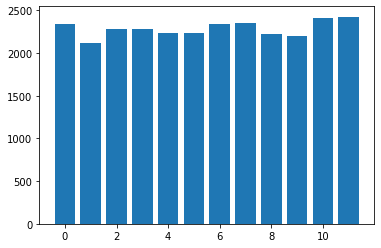

In [12]:
plt.bar(x=range(12), height=layer_scores)
plt.show()

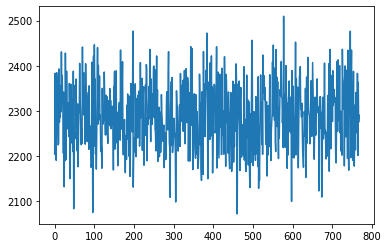

In [13]:
sns.lineplot(x=range(768), y=weight_scores)
plt.show()

In [ ]:
layer_indices = np.argsort(layer_scores)[:6].tolist()
weight_indices = np.argsort(weight_scores)[:384].tolist()

In [ ]:
pruned = copy.deepcopy(model)
pruned = select_bert_model(pruned, layer_indices, weight_indices)

In [212]:
pruned.config.hidden_size = 384
pruned.config.num_hidden_layers = 6

pruned.save_pretrained('../init/transformers')
tokenizer.save_pretrained('../init/transformers')

('../init/transformers/tokenizer_config.json',
 '../init/transformers/special_tokens_map.json',
 '../init/transformers/vocab.txt',
 '../init/transformers/added_tokens.json',
 '../init/transformers/tokenizer.json')